# Predictive Modelling of Proteomics using a Transformer Model

## Task Type and Model Decision
This task is a regression task, where one type of omics data is predicted using others. Both VAEs and Transformers are suitable choices: VAEs excel with noisy data and handle missing values well, while Transformers are powerful for capturing complex interactions between features through their self-attention mechanism.

I selected a Transformer model because the multi-head attention can learn different types of relationships between omics data features and capturing various correlations that might exist. The self-attention mechanism allows the model to identify important feature interactions, which I think are important in multi-omics data integration. While VAEs would also be suitable, particularly for handling noise and missing values, the potential complex interactions between omics data features made Transformers my preferred choice.

## Data
The aim is to use multiple input omics datasets to predict proteomics data. Input omics data was selected by iteratively testing combinations to determine which best predicted proteomics. This indicated that transcriptomics data only as the optimal input combination for proteomics prediction.

## Plan
The approach follows a systematic comparison between a baseline MLP model and the Transformer architecture:

#### In EMBL_transformer_explore.ipynb
1. [Inspect data](#inspect-data);
2. [Create a simple MLP model](#baseline-mlp) as a baseline;
3. [Develop Transformer models](#transformer-models) with different fusion strategies and activation functions;
4. [Perform hyperparameter tuning](#hyperparameter-tuning);
5. [Conduct progressive input omics selection](#omics-selection);
6. [Create comprehensive loop](#evaluation-loop) to iterate through steps 3-5, obtaining metrics to determine the best Transformer model for comparison with the baseline MLP;

#### In EMBL_transformer_best_model.ipynb
7. [Select best-performing model](#best-performing);
8. [Analyse best-predicted proteomic features](#feature-analysis);


## Results
- The [baseline MLP model](#results-MLP) performed quite well already, with an R^2 ~0.83, an RMSE ~0.69, and prediction errors that are roughly Normally distributed.
- The best [Transformer model](#results-transformer) demonstrated that using transcriptomics data only as input omics data performed best, with R^2 ~0.83. However, rerunning the algorithm shows some variability in the best performing hyperparameters, such as fusion method selected. In addition, the Transformer model does not significantly outperform the baseline MLP model. Moving forward, cross-validation and improved data handling (e.g. outlier handling) would be worth exploring. 
- The results of the [feature analysis](#results-feature-analysis) showed significant correlation values >0.5 between the predicted and actual values. However, the R^2 values are low, indicating that while the general trends in protein expression are captured, the model does not accurately predict the exact values. 

## Future Work
Given more time, I would implement:

1. Cross-validation for more robust model evaluation;
2. Enhanced data handling, particularly for outliers. Despite the task stating the data was "processed and cleaned, so you can use them directly" I encountered outliers that might affect results. Going forward, I would address these outliers prior to modelling;
3. Development of ensemble methods to potentially improve prediction accuracy.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# for using VSCode
import sys
from pathlib import Path

# Add the parent directory of transformer_multiomics to sys.path
sys.path.append(str(Path.cwd().parent))

In [3]:
from transformer_multiomics.config import MODEL_PATH, RESULT_PATH, DATA_PATH
from transformer_multiomics.data.data_loader import ensure_directories_exist, load_datasets
from transformer_multiomics.data.data_preparation import get_multiomics_dataloaders
from transformer_multiomics.models.mlp import MultiOmicsMLP
from transformer_multiomics.models.transformer import RefinedOmicsTransformer
from transformer_multiomics.training.trainer import train_model
from transformer_multiomics.utils.plots import plot_loss_curves, plot_error_distribution
from transformer_multiomics.training.evaluater import evaluate_model

In [4]:
# CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Ensure directories exist
ensure_directories_exist(MODEL_PATH, RESULT_PATH, DATA_PATH)

# Load datasets
datasets = load_datasets()
print("Available datasets:", datasets.keys())

Directory exists: /home/jantine/Projects/transformer_multiomics/models
Directory exists: /home/jantine/Projects/transformer_multiomics/results
Directory exists: /home/jantine/Projects/transformer_multiomics/datasets
Available datasets: dict_keys(['methylation', 'metabolomics', 'proteomics', 'transcriptomics', 'cnv'])


In [6]:
# Choose input data set and target
input_datasets = ["transcriptomics", "methylation", "metabolomics", "cnv"]  # as many as you want
target_dataset = "proteomics"

train_loader, test_loader = get_multiomics_dataloaders(
    datasets=datasets,
    input_omics=input_datasets,
    target_omics=target_dataset,
    batch_size=32,
    test_size=0.2
)

# Define input dims per omics
input_dims_dict = {
    omic: datasets[omic].shape[1] - 1  # exclude patient ID column
    for omic in input_datasets
}

# Output dimension (target omic)
output_dim = datasets[target_dataset].shape[1] - 1

In [ ]:
# Initialize model with multi-omics input dims
mlp_model = MultiOmicsMLP(
    input_dims_dict=input_dims_dict,
    output_dim=output_dim,
    hidden_dims=[256, 128, 64]
).to(device)

# Loss function and optimiser
mlp_criterion = nn.MSELoss()
learning_rate = 0.001
weight_decay = 0
mlp_optimiser = optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Early stopping setup
patience = 15
epochs = 100

mlp_model = MultiOmicsMLP(
    input_dims_dict=input_dims_dict,
    output_dim=output_dim,
    hidden_dims=[256, 128, 64]
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=0)

trained_model, train_losses, test_losses, best_loss = train_model(
    model=mlp_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    patience=patience,
    model_name="multiomics_mlp",
    save_path=MODEL_PATH,
    return_attention_weights=False
)



Starting training for multiomics_mlp...


Epoch 1/100 | Train Loss: 21.4933 | Test Loss: 17.1240 | Early Stopping: 0/15


Epoch 11/100 | Train Loss: 0.9273 | Test Loss: 0.8273 | Early Stopping: 0/15


Epoch 21/100 | Train Loss: 0.4428 | Test Loss: 0.4914 | Early Stopping: 1/15


Epoch 31/100 | Train Loss: 0.4774 | Test Loss: 0.5373 | Early Stopping: 6/15



Early stopping at epoch 40
Best model saved to /home/jantine/Projects/transformer_multiomics/models/best_multiomics_mlp_model.pt


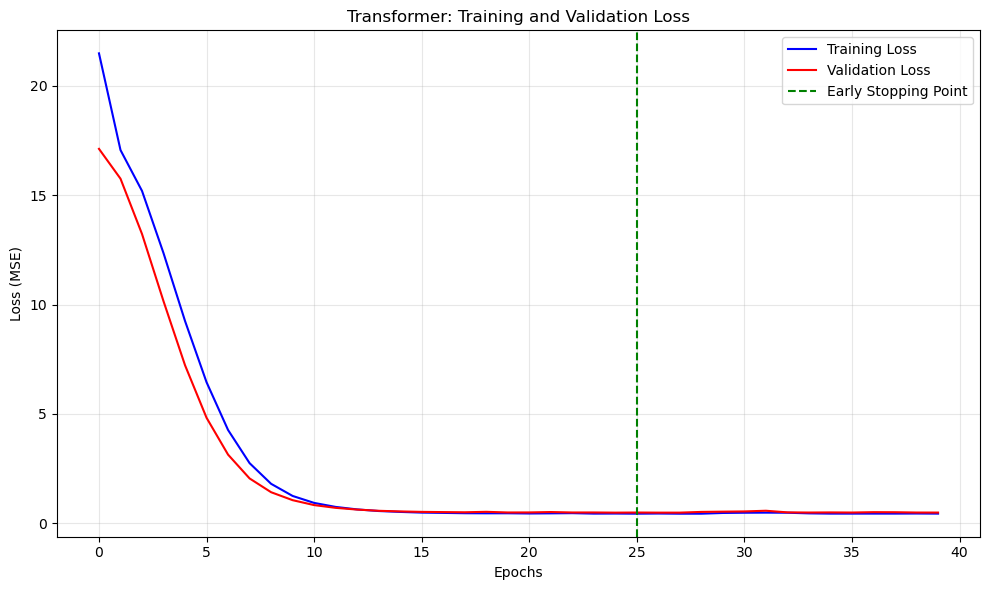

In [8]:
# Plot training and validation loss curves
early_stopping_epoch = len(test_losses) - patience
plot_loss_curves(
    train_losses,
    test_losses,
    early_stopping_epoch=early_stopping_epoch,
    title="Transformer: Training and Validation Loss"
)

In [16]:
# Evaluate model performance
metrics_mlp = evaluate_model(mlp_model, test_loader, device, is_transformer=False, model_name="MLP")

Evaluating MLP: 100%|██████████| 2/2 [00:00<00:00, 155.36it/s]

MLP Performance:
R-squared (R²): 0.8371
Root Mean Squared Error (RMSE): 0.6964
Mean Absolute Error (MAE): 0.5134
Explained Variance Score: 0.8385


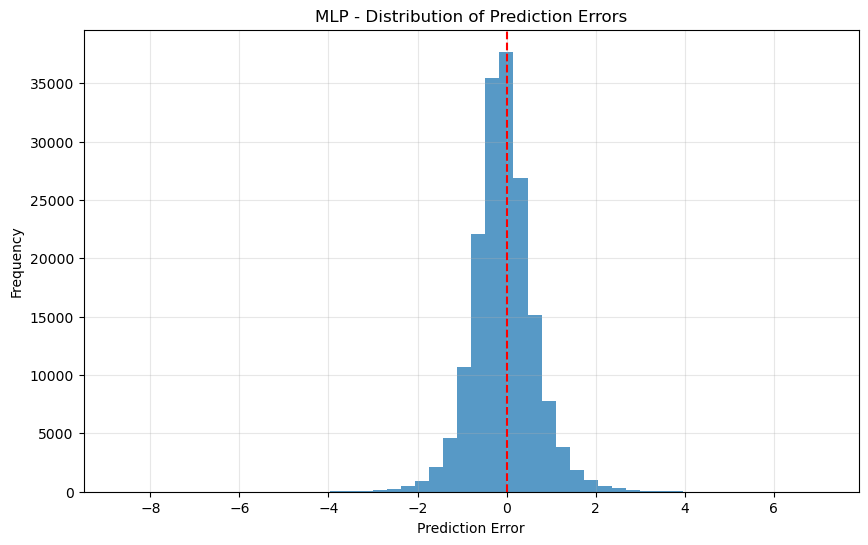

In [10]:
# Plot error distribution
all_predictions = metrics_mlp["predictions"]
all_targets = metrics_mlp["targets"]

plot_error_distribution(all_predictions, all_targets, model_name="MLP")


# Baseline MLP Results <a id="results-MLP"></a>

The MLP is performing quite well already, with R^2 of ~0.83 and the error distribution normally distributed. The errors look Normally distributed, so the MLP is already performing well without systematically overestimating/underestimating the target values. 

# Transformer <a id="transformer-models"></a> 

This part is the development of the Transformer model. The Transformer model is designed so that it can be used to iteratively scan through different combinations of input omics data, fusion strategies, activation function (only ReLU and GeLU, as I'm working with PyTorch), and for hyperparameter optimisation.

# Training

In [ ]:
# Initialize model with multi-omics input dims
transformer_model = RefinedOmicsTransformer(
    input_dims=input_dims_dict,
    output_dim=output_dim,
    hidden_dim=256,  # 256, 512, -> Larger embedding space
    num_heads=4,     # 4, 8, 16 -> More attention heads
    num_layers=4,   # 4, 8 -> Deeper transformer
    dropout=0.01,     # Regularization
    use_batch_norm=False, 
    use_input_norm=False,
    activation_fn="gelu",  # "gelu", "relu", "identity"
    use_modality_embedding=False,
    pooling_type="attention"  # "attention", "mean", "max", "concat"
).to(device)

# Loss function and optimiser
transformer_criterion = nn.MSELoss()
learning_rate = 0.001
weight_decay = 0
transformer_optimiser = optim.AdamW(transformer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Early stopping setup
patience = 20
epochs = 100

transformer_model = RefinedOmicsTransformer(
    input_dims=input_dims_dict,
    output_dim=output_dim,
    hidden_dim=256,
    num_heads=4,
    num_layers=4,
    dropout=0.01,
    use_batch_norm=False,
    use_input_norm=False,
    activation_fn="gelu",
    use_modality_embedding=False,
    pooling_type="attention"
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(transformer_model.parameters(), lr=0.001, weight_decay=0)

result = train_model(
    model=transformer_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=100,
    patience=20,  # Different patience for transformer
    model_name="multiomics_transformer",
    save_path=MODEL_PATH,
    return_attention_weights=True  # Transformer returns attention weights
)

# Unpack results - attention weights are returned as the 5th element
trained_model, train_losses, test_losses, best_loss, attention_weights = result




/home/jantine/miniconda3/envs/transformer_multiomics/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Starting training for multiomics_transformer...


Epoch 1/100 | Train Loss: 13.1385 | Test Loss: 7.7081 | Early Stopping: 0/20


Epoch 11/100 | Train Loss: 0.5047 | Test Loss: 0.5301 | Early Stopping: 3/20


Epoch 21/100 | Train Loss: 0.4678 | Test Loss: 0.5408 | Early Stopping: 7/20


Epoch 31/100 | Train Loss: 0.4039 | Test Loss: 0.4915 | Early Stopping: 1/20


Epoch 41/100 | Train Loss: 0.3591 | Test Loss: 0.4378 | Early Stopping: 3/20


Epoch 51/100 | Train Loss: 0.3367 | Test Loss: 0.4074 | Early Stopping: 13/20



Early stopping at epoch 58
Best model saved to /home/jantine/Projects/transformer_multiomics/models/best_multiomics_transformer_model.pt


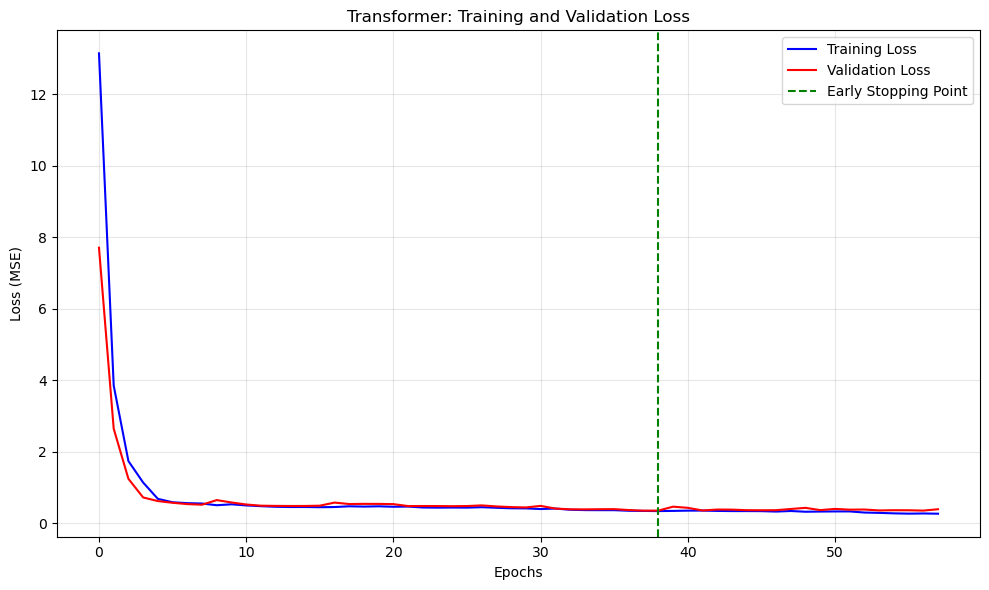

In [12]:
# Plot training and validation loss curves
early_stopping_epoch = len(test_losses) - patience
plot_loss_curves(
    train_losses,
    test_losses,
    early_stopping_epoch=early_stopping_epoch,
    title="Transformer: Training and Validation Loss"
)

In [13]:
# Evaluate model performance
metrics_transformer = evaluate_model(transformer_model, test_loader, device, is_transformer=True, model_name="Transformer")


Evaluating Transformer: 100%|██████████| 2/2 [00:00<00:00, 148.36it/s]

Transformer Performance:
R-squared (R²): 0.8663
Root Mean Squared Error (RMSE): 0.6308
Mean Absolute Error (MAE): 0.4666
Explained Variance Score: 0.8740


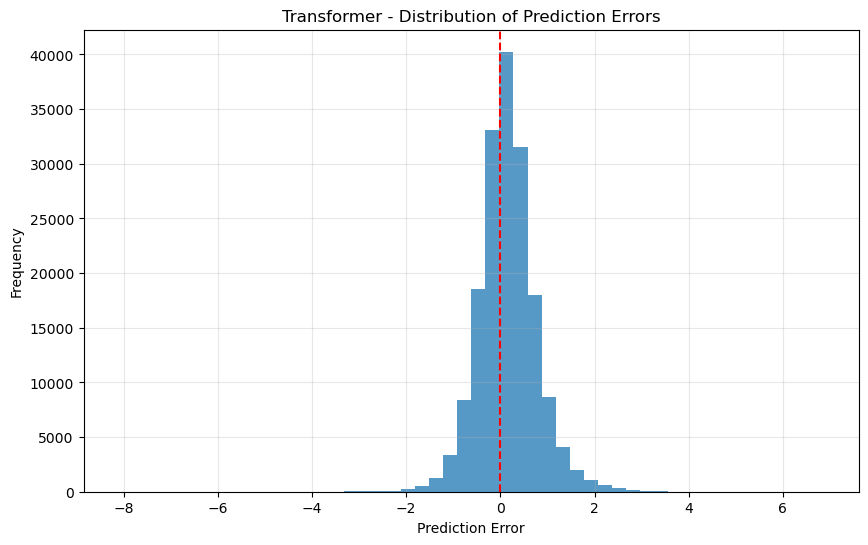

In [14]:
# Plot error distribution
all_predictions = metrics_transformer["predictions"]
all_targets = metrics_transformer["targets"]

plot_error_distribution(all_predictions, all_targets, model_name="Transformer")

In [15]:
# global importance of each omics type
# Concatenate and average across samples
attn_tensor = torch.cat(attention_weights, dim=0)  # shape: [num_samples, num_modalities]
avg_attention = attn_tensor.mean(dim=0)

print("Average attention per modality:", avg_attention)

Average attention per modality: tensor([0.1305, 0.2593, 0.2900, 0.3202])
